In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

TRIPS_CSV = "Trips_2018.csv"
TRIPS_CSV_PROXY = "Trips_2018_short.csv"
PROXY_USAGE = False

#df = pd.read_csv("Trips_2018.csv")
#short_df = df.head(1000)
#short_df.to_csv("Trips_2018_short.csv", index=False)


df_path = TRIPS_CSV_PROXY if PROXY_USAGE else TRIPS_CSV
df = pd.read_csv(df_path)

df = df.drop('Unnamed: 0', axis=1)

print(df.shape)
df.head()




(17548339, 13)


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


In [2]:
min_duration = df['tripduration'].min()
max_duration = df['tripduration'].max()

# Calculate outliers using IQR method
Q1 = df['tripduration'].quantile(0.05)
Q3 = df['tripduration'].quantile(0.95)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = df[(df['tripduration'] < lower_bound) | (df['tripduration'] > upper_bound)]
n_outliers = len(outliers)

print(f"Min trip duration: {min_duration} seconds ({min_duration/60:.1f} minutes)")
print(f"Max trip duration: {max_duration} seconds ({max_duration/60:.1f} minutes)")
print(f"\nOutlier boundaries:")
print(f"Lower bound: {lower_bound:.1f} seconds ({lower_bound/60:.1f} minutes)")
print(f"Upper bound: {upper_bound:.1f} seconds ({upper_bound/60:.1f} minutes)")
print(f"\nFound {n_outliers} outliers ({(n_outliers/len(df)*100):.2f}% of all trips)")

Min trip duration: 61 seconds (1.0 minutes)
Max trip duration: 19510049 seconds (325167.5 minutes)

Outlier boundaries:
Lower bound: -2685.0 seconds (-44.8 minutes)
Upper bound: 4931.0 seconds (82.2 minutes)

Found 95678 outliers (0.55% of all trips)


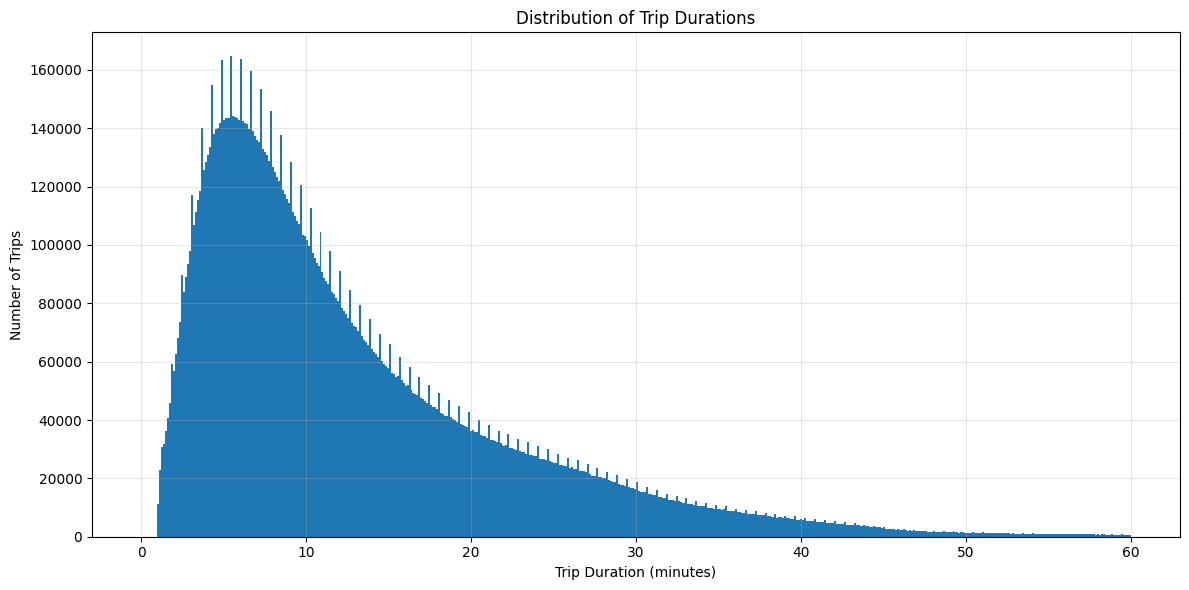

In [6]:
df['tripduration_minutes'] = df['tripduration'] / 60

# Create a histogram of trip durations (in minutes)
plt.figure(figsize=(12, 6))
plt.hist(df['tripduration_minutes'], bins=500, range=(0, 60))
plt.title('Distribution of Trip Durations')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Number of Trips')
plt.grid(True, alpha=0.3)
plt.tight_layout()

C:\Users\Tomi\AppData\Local\Temp\ipykernel_13888\2390237251.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['start_hour'] = df['start_time'].dt.floor('H')


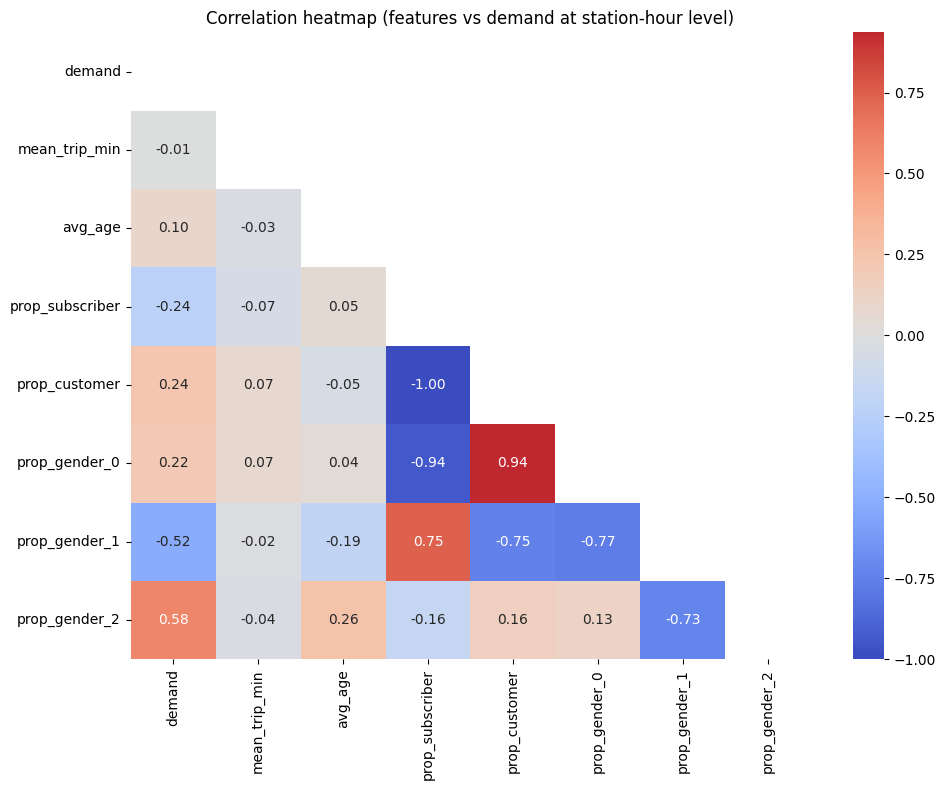

Top positive correlations with demand:
demand             1.000000
prop_gender_2      0.581557
prop_customer      0.235552
prop_gender_0      0.216140
avg_age            0.096328
mean_trip_min     -0.007301
prop_subscriber   -0.235552
prop_gender_1     -0.523053
Name: demand, dtype: float64

Top negative correlations with demand:
prop_gender_1     -0.523053
prop_subscriber   -0.235552
mean_trip_min     -0.007301
avg_age            0.096328
prop_gender_0      0.216140
prop_customer      0.235552
prop_gender_2      0.581557
demand             1.000000
Name: demand, dtype: float64


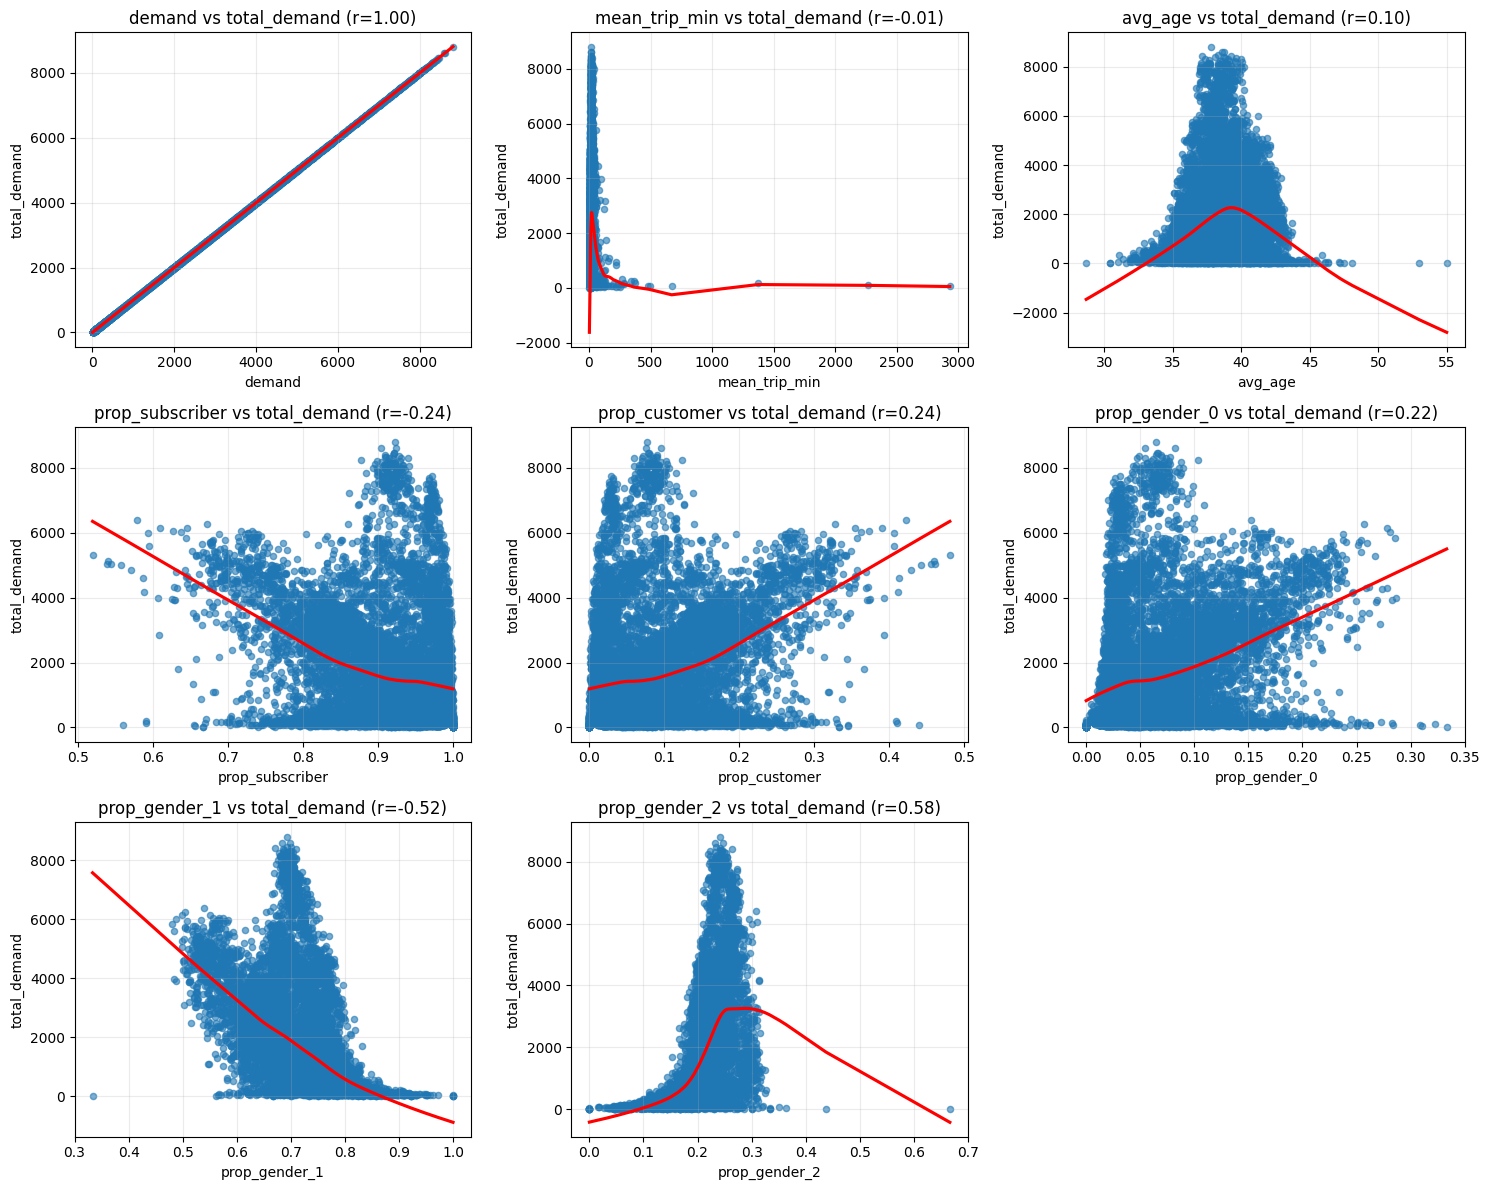

In [5]:
import seaborn as sns

df['start_time'] = pd.to_datetime(df['starttime'])
df['start_hour'] = df['start_time'].dt.floor('H')

# Aggregate to station-hour level to represent "demand" (number of departures)
agg = df.groupby(["start_hour"]).agg(
    demand=("tripduration", "size"),
    mean_trip_min=("tripduration_minutes", "mean"),
    avg_age=("birth_year", lambda x: (2018 - x).mean()),
    prop_subscriber=("usertype", lambda x: (x == "Subscriber").mean()),
    prop_customer=("usertype", lambda x: (x == "Customer").mean()),
    prop_gender_0=("gender", lambda x: (x == 0).mean()),
    prop_gender_1=("gender", lambda x: (x == 1).mean()),
    prop_gender_2=("gender", lambda x: (x == 2).mean())
).reset_index()

# Keep only numeric columns for correlation
num = agg.select_dtypes(include=[np.number]).fillna(0)

# Correlation matrix and heatmap
corr = num.corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation heatmap (features vs demand at station-hour level)")
plt.tight_layout()
plt.show()

# Print features most correlated with demand
print("Top positive correlations with demand:")
print(corr["demand"].sort_values(ascending=False).head(8))
print("\nTop negative correlations with demand:")
print(corr["demand"].sort_values().head(8))

# Plot each feature against total_demand with a lowess regression line and correlation in the title
features = [c for c in num.columns if c != "total_demand"]
n = len(features)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for ax, feat in zip(axes, features):
    # scatter + smooth fit
    sns.regplot(x=feat, y="demand", data=num,
                lowess=True,
                scatter_kws={"s": 20, "alpha": 0.6},
                line_kws={"color": "red"},
                ax=ax)
    # correlation (use corr computed earlier)
    r = corr.loc[feat, "demand"]
    ax.set_title(f"{feat} vs total_demand (r={r:.2f})")
    ax.set_xlabel(feat)
    ax.set_ylabel("total_demand")
    ax.grid(alpha=0.25)

# turn off any unused subplots
for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [4]:
for f in ["starttime", "stoptime"]:
    df[f] = pd.to_datetime(df[f], format="%Y-%m-%d %H:%M:%S.%f")

# Basic sanity: drop rows without station info
df = df.dropna(subset=["start_station_id","end_station_id",
                       "start_station_latitude","start_station_longitude",
                       "end_station_latitude","end_station_longitude"])

df["start_hour"] = df["starttime"].dt.floor("H")
df["stop_hour"]  = df["stoptime"].dt.floor("H")

df.head()

C:\Users\Tomi\AppData\Local\Temp\ipykernel_16292\3914380608.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["start_hour"] = df["starttime"].dt.floor("H")
C:\Users\Tomi\AppData\Local\Temp\ipykernel_16292\3914380608.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["stop_hour"]  = df["stoptime"].dt.floor("H")


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_hour,stop_hour
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,2018-01-01 13:00:00,2018-01-01 14:00:00
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,2018-01-01 15:00:00,2018-01-01 15:00:00
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,2018-01-01 15:00:00,2018-01-01 15:00:00
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,2018-01-01 15:00:00,2018-01-01 15:00:00
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,2018-01-01 18:00:00,2018-01-01 18:00:00


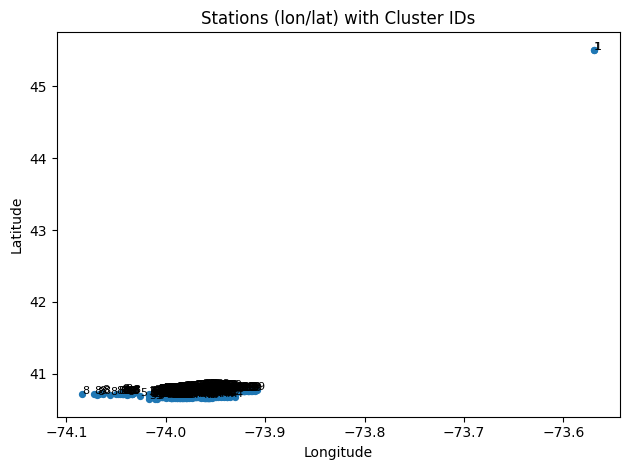

In [5]:
from sklearn.cluster import KMeans

start_st = df[["start_station_id","start_station_latitude","start_station_longitude"]].drop_duplicates()
start_st.columns = ["station_id","lat","lon"]
end_st = df[["end_station_id","end_station_latitude","end_station_longitude"]].drop_duplicates()
end_st.columns = ["station_id","lat","lon"]

stations = pd.concat([start_st, end_st], ignore_index=True).drop_duplicates(subset=["station_id"]).reset_index(drop=True)
n_stations = len(stations)
#n_clusters = max(1, min(20, n_stations))
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
stations["cluster"] = kmeans.fit_predict(stations[["lat","lon"]])

cluster_map = stations.set_index("station_id")["cluster"].to_dict()
df["pickup_cluster"]  = df["start_station_id"].map(cluster_map)
df["dropoff_cluster"] = df["end_station_id"].map(cluster_map)

stations.head()

plt.figure()
plt.scatter(stations["lon"], stations["lat"], s=18)
for _, r in stations.iterrows():
    plt.text(r["lon"], r["lat"], str(int(r["cluster"])), fontsize=8)
plt.title("Stations (lon/lat) with Cluster IDs")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.tight_layout()

In [6]:
start_st = df[["start_station_id","start_station_latitude","start_station_longitude"]].drop_duplicates()
start_st.columns = ["station_id","lat","lon"]

end_st = df[["end_station_id","end_station_latitude","end_station_longitude"]].drop_duplicates()
end_st.columns = ["station_id","lat","lon"]


stations = pd.concat([start_st, end_st], ignore_index=True).drop_duplicates(subset=["station_id"]).reset_index(drop=True)
print(f"Unique stations: {len(stations)}")
stations.head()
# Remove stations that are far from the bulk using a robust distance-based rule (IQR on haversine distance).
# Then report how many trip records reference those outlier stations.

def haversine(lon1, lat1, lon2, lat2):
    # all args are arrays or scalars in degrees
    R = 6371.0  # Earth radius in km
    lon1r, lat1r = np.radians(lon1), np.radians(lat1)
    lon2r, lat2r = np.radians(lon2), np.radians(lat2)
    dlon = lon1r - lon2r
    dlat = lat1r - lat2r
    a = np.sin(dlat/2.0)**2 + np.cos(lat1r) * np.cos(lat2r) * np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# use the geographic median (median lat/lon) as a robust center
center_lat = stations['lat'].median()
center_lon = stations['lon'].median()

# compute distances (km) from center
dist_km = haversine(stations['lon'].values, stations['lat'].values, center_lon, center_lat)

# detect outliers using IQR rule on distances
q1, q3 = np.percentile(dist_km, [25, 75])
iqr = q3 - q1
threshold_km = q3 + 1.5 * iqr

outlier_mask = dist_km > threshold_km
outlier_stations = stations.loc[outlier_mask, 'station_id'].tolist()

# how many unique stations and how many trip records reference them
n_outlier_stations = len(outlier_stations)
n_trip_using_outliers = df['start_station_id'].isin(outlier_stations).sum() + df['end_station_id'].isin(outlier_stations).sum()

# keep non-outlier stations
stations = stations.loc[~outlier_mask].reset_index(drop=True)

print(f"Center (median): lat={center_lat:.6f}, lon={center_lon:.6f}")
print(f"Distance threshold (IQR rule): {threshold_km:.2f} km")
print(f"Found {n_outlier_stations} outlier stations.")
print(f"Trip records referencing those outlier stations (start OR end counted separately): {n_trip_using_outliers}")
print(f"Stations before: {len(outlier_mask)} ; after cleaning: {len(stations)}")

# show the outlier stations (if any)
if n_outlier_stations:
    print(outlier_stations)
else:
    print("No outlier stations detected.")


Unique stations: 850
Center (median): lat=40.730233, lon=-73.976131
Distance threshold (IQR rule): 11.20 km
Found 2 outlier stations.
Trip records referencing those outlier stations (start OR end counted separately): 163
Stations before: 850 ; after cleaning: 848
[3488.0, 3650.0]


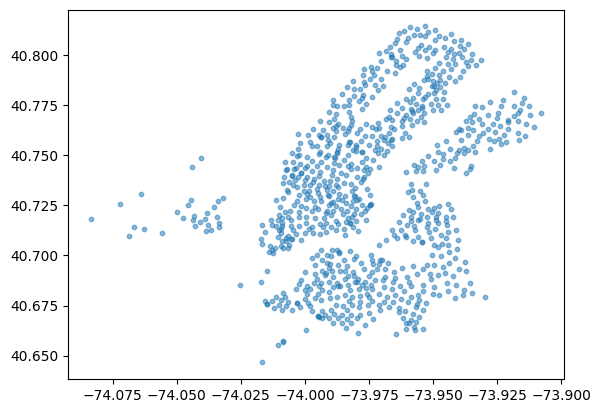

In [52]:
plt.scatter(stations['lon'], stations['lat'], s=10, alpha=0.5)

(848, 3)


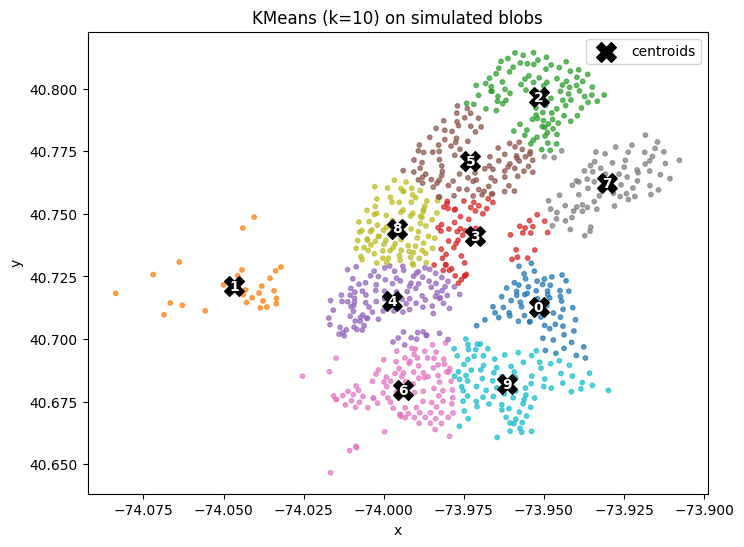

In [10]:
# Run KMeans on the 2-D points and plot centroids + colored points
from sklearn.cluster import KMeans

print(stations.shape)

K = 10
kmeans = KMeans(n_clusters=K, random_state=42)
labels = kmeans.fit_predict(stations[['lon', 'lat']].values)
centers = kmeans.cluster_centers_

plt.figure(figsize=(8,6))
plt.scatter(stations['lon'], stations['lat'], c=labels, cmap='tab10', s=10, alpha=0.7)
plt.scatter(centers[:,0], centers[:,1], c='black', marker='X', s=200, label='centroids')
for i, c in enumerate(centers):
    plt.text(c[0], c[1], str(i), color='white', weight='bold', ha='center', va='center')
plt.title(f'KMeans (k={K}) on simulated blobs')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [7]:
from meteostat import Hourly, Stations
from datetime import datetime
import pandas as pd

# Find the closest station to Manhattan (example: Central Park vicinity)
stations = Stations().nearby(40.783, -73.966).inventory('hourly')
station = stations.fetch(1).iloc[0]  # top match
start, end = datetime(2018, 1, 1), datetime(2019, 1, 1)

data = Hourly(station['id'], start, end).fetch()
# data has hourly: temp, precip, wind, etc., index is datetime (UTC)
data.to_csv("nyc_weather_hourly_2018_meteostat.csv")
print(station)


KeyError: 'id'

In [8]:
from meteostat import Hourly, Stations
from datetime import datetime

# Find the closest station to Manhattan (example: Central Park vicinity)
stations = Stations().nearby(40.783, -73.966).inventory('hourly')
station = stations.fetch(1).iloc[0]  # top match
start, end = datetime(2018, 1, 1), datetime(2019, 1, 1)

data = Hourly(station.name, start, end).fetch()
print("Data shape:", data.shape)
print("\nFirst few rows:")
print(data.head())


Data shape: (0, 11)

First few rows:
Empty DataFrame
Columns: [temp, dwpt, rhum, prcp, snow, wdir, wspd, wpgt, pres, tsun, coco]
Index: []


In [16]:
from meteostat import Hourly, Point
from datetime import datetime

# Central Park area
cp = Point(40.783, -73.966)

start, end = datetime(2018, 1, 1), datetime(2019, 1, 1)
data = Hourly(cp, start, end, timezone='America/New_York').fetch()
data.to_csv("nyc_weather_hourly_2018_meteostat.csv")

print("Data shape:", data.shape)
print(data.head())


Data shape: (8761, 11)
                           temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
time                                                                         
2018-01-01 00:00:00-05:00 -10.6 -15.5  67.0   0.0  <NA>  340.0  11.2  <NA>   
2018-01-01 01:00:00-05:00 -11.1 -17.1  61.0   0.0  <NA>  330.0   9.4  <NA>   
2018-01-01 02:00:00-05:00 -11.7 -17.1  64.0   0.0  <NA>  330.0   7.6  <NA>   
2018-01-01 03:00:00-05:00 -11.7 -17.1  64.0   0.0  <NA>  330.0   7.6  <NA>   
2018-01-01 04:00:00-05:00 -11.7 -17.1  64.0   0.0  <NA>  310.0  11.2  <NA>   

                             pres  tsun  coco  
time                                           
2018-01-01 00:00:00-05:00  1026.9  <NA>  <NA>  
2018-01-01 01:00:00-05:00  1027.1  <NA>  <NA>  
2018-01-01 02:00:00-05:00  1027.4  <NA>  <NA>  
2018-01-01 03:00:00-05:00  1027.6  <NA>  <NA>  
2018-01-01 04:00:00-05:00  1027.7  <NA>  <NA>  


In [14]:
from meteostat import Hourly, Stations
from datetime import datetime

# Find a nearby station *with hourly inventory*
stations = Stations().nearby(40.783, -73.966).inventory('hourly')
df = stations.fetch(5)           # inspect a few candidates
print(df)                        # see IDs & names

# The ID is the **index**, not a column; use df.index[0]
station_id = df.index[0]
print("Chosen station ID:", station_id, "| Name:", df.iloc[0]['name'])

start, end = datetime(2018, 1, 1), datetime(2019, 1, 1)
data = Hourly(station_id, start, end, timezone='America/New_York').fetch()
data.to_csv("nyc_weather_hourly_2018_meteostat.csv")

print("Data shape:", data.shape)
print(data.head())


                            name country region    wmo  icao  latitude  \
id                                                                       
KNYC0  New York City / Yorkville      US     NY   <NA>  KNYC   40.7789   
KJRB0     New York / Wall Street      US     NY   <NA>  KJRB   40.7012   
KTEB0                  Teterboro      US     NJ   <NA>  KTEB   40.8501   
72502             Newark Airport      US     NJ  72502  KEWR   40.6833   
74486    John F. Kennedy Airport      US     NY  74486  KJFK   40.6333   

       longitude  elevation          timezone hourly_start hourly_end  \
id                                                                      
KNYC0   -73.9692        3.0  America/New_York   1943-12-01 2025-11-01   
KJRB0   -74.0090        2.0  America/New_York   2016-07-20 2025-11-01   
KTEB0   -74.0608        3.0  America/New_York   1973-01-01 2025-11-01   
72502   -74.0000        5.0  America/New_York   1973-01-01 2025-11-01   
74486   -73.7667        4.0  America/New_Yo